In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from transformers import ViTModel, BertModel, BertTokenizer, ViTFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class ImageTextDataset(Dataset):
    def __init__(self, root_dir, tokenizer_name, feature_extractor_name):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(feature_extractor_name)
        self.synthetic_texts = {
            'glioma_tumor': ["MRI shows aggressive glioma in frontal region.", "Large glioma mass with edema."],
            'meningioma_tumor': ["Benign meningioma near the dura.", "Dome-shaped meningioma observed."],
            'no_tumor': ["Normal brain scan with no abnormalities.", "No tumor detected in the scan."],
            'pituitary_tumor': ["Enlarged pituitary gland indicates tumor.", "Tumor seen in pituitary region."]
        }
        self.label_map = {v: k for k, v in self.dataset.class_to_idx.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        class_name = self.label_map[label]
        synthetic_text = random.choice(self.synthetic_texts[class_name])
        
        image = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        text_inputs = self.tokenizer(synthetic_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        text_inputs = {k: v.squeeze(0) for k, v in text_inputs.items()}

        return image, text_inputs, label


In [3]:
class CrossModalModel(nn.Module):
    def __init__(self, num_classes):
        super(CrossModalModel, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.bert = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.fusion = nn.Linear(self.vit.config.hidden_size + self.bert.config.hidden_size, 512)
        self.classifier = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, image_input, text_input):
        img_feat = self.vit(pixel_values=image_input).last_hidden_state[:, 0, :]
        txt_feat = self.bert(**text_input).last_hidden_state[:, 0, :]
        combined = torch.cat((img_feat, txt_feat), dim=1)
        fused = self.dropout(torch.relu(self.fusion(combined)))
        return self.classifier(fused)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ImageTextDataset("Dataset/Training", "emilyalsentzer/Bio_ClinicalBERT", "google/vit-base-patch16-224-in21k")
test_dataset = ImageTextDataset("Dataset/Testing", "emilyalsentzer/Bio_ClinicalBERT", "google/vit-base-patch16-224-in21k")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

class_names = list(train_dataset.dataset.class_to_idx.keys())
model = CrossModalModel(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


c:\Users\srava\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
model.train()
for epoch in range(5):  # One epoch for demonstration
    for image, text_input, label in train_loader:
        image = image.to(device)
        text_input = {k: v.to(device) for k, v in text_input.items()}
        label = label.to(device)

        outputs = model(image, text_input)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} complete. Loss: {loss.item():.4f}")


Epoch 1 complete. Loss: 0.0018
Epoch 2 complete. Loss: 0.0006
Epoch 3 complete. Loss: 0.0001
Epoch 4 complete. Loss: 0.0001
Epoch 5 complete. Loss: 0.0001


 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      1.00      1.00       100
meningioma_tumor       1.00      1.00      1.00       115
        no_tumor       1.00      1.00      1.00       105
 pituitary_tumor       1.00      1.00      1.00        74

        accuracy                           1.00       394
       macro avg       1.00      1.00      1.00       394
    weighted avg       1.00      1.00      1.00       394

 Accuracy: 100.00%


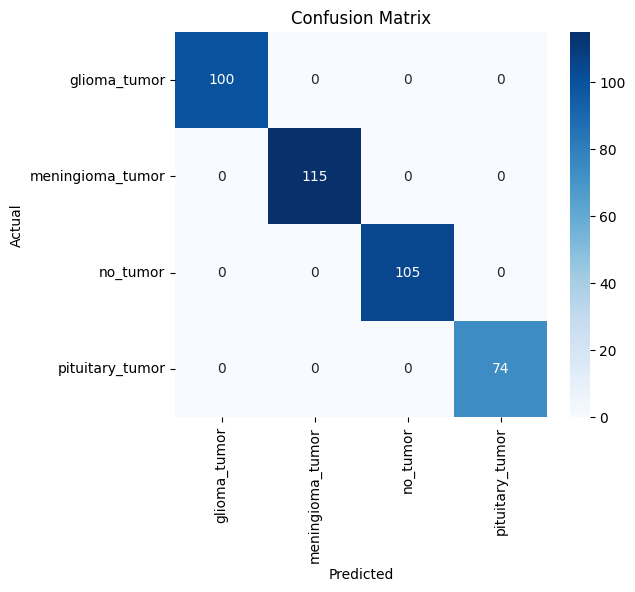

In [6]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for image, text_input, label in test_loader:
        image = image.to(device)
        text_input = {k: v.to(device) for k, v in text_input.items()}
        label = label.to(device)

        outputs = model(image, text_input)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

print(" Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print(f" Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
